In [1]:
import sys
import os
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
import scipy.sparse as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn
import random
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
import time

cwd = os.getcwd()
par = os.path.dirname(cwd)
sys.path.append(par)
import diffusionNMF
import grid_search
from diffusionNMF import diffusionNMF
from grid_search import gridSearcher

%load_ext autoreload
%autoreload 2

### Generate synthetic data

In [2]:
def gen_sin_data(rank, freqs = None):
    if freqs is not None and rank != len(freqs):
        print("Rank needs to be same length as frequencies")
        return
    
    test_h = sp.random(rank,52, density = 0.07).A
    
    # generate new H if we have any zero rows
    while np.where(np.sum(test_h, axis = 1) == 0)[0].size != 0:
        test_h = sp.random(rank, 52, density = 0.07).A
     
    # Normalize row sums of H so that they all sum to 1
    for g in range(len(test_h)):
        scal = test_h[g,:].sum()
        test_h[g,:] /= scal

    H = pd.DataFrame(test_h)
    
    waves = []
    time = np.linspace(1,100,100)
    for i in range(rank):
        if freqs is None:
            freq = np.random.normal(0,0.2)
        else:
            freq = freqs[i]
        waves.append((i + 1) * np.sin(freq * time))
        
    W = pd.DataFrame(waves).T
    W /= W.max().max() * 2
    W += 0.5
    
    return W,H

In [14]:
W = pd.read_csv('testing_data/W_4.csv',index_col=0)
H = pd.read_csv('testing_data/H_4.csv',index_col=0)

In [15]:
rank = 4
#rr = np.random.RandomState(1729)
#freqs = rr.normal(0.0, 0.2, 20)
freqs = [-0.1374, -0.16419894, 0.33047217, -0.11505861, 0.21979355, 0.18518921,
         -0.19868276, -0.17164423, 0.01497735, 0.10587111, 0.02419031, -0.04488472,
         -0.3113357, 0.01118818, 0.03229431, -0.42692835, 0.02193401, 0.08860243, 
         0.07925325, 0.04995948]

#W,H = gen_sin_data(rank, freqs[:rank])

Text(0.5, 1.0, 'Sparse H')

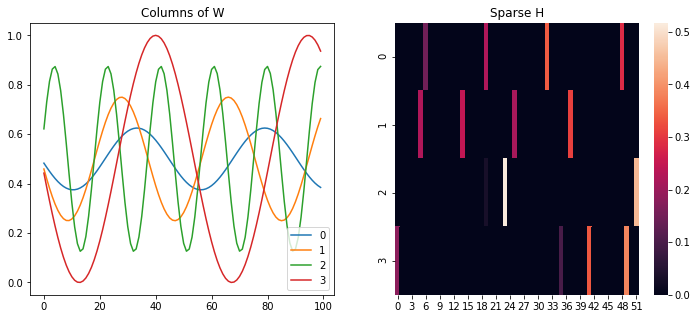

In [16]:
fig, ax = plt.subplots(1,2,figsize = (12,5))
W.plot(ax=ax[0])
ax[0].set_title("Columns of W")
seaborn.heatmap(H, square = False, cbar = True, ax = ax[1])
ax[1].set_title("Sparse H")

In [6]:
#W.to_csv("./testing_data/W_4.csv")
#H.to_csv("./testing_data/H_4.csv")

In [17]:
# calculate sparseness of H
# based on the hoyer definition of sparseness
def h_sparseness(h):
    h_sparse = 0
    for row in h.index:
        rh = np.array(h.loc[row,:])
        sp = math.sqrt(len(rh)) - (sum(np.abs(rh))/ math.sqrt(sum(rh ** 2)))
        sp /= (math.sqrt(len(rh)) - 1)
        h_sparse += sp
    
    h_sparse /= len(h.index)
    
    return h_sparse

In [18]:
h_sparse = h_sparseness(H)
h_sparse

0.8722241499297612

### Initial Test

In [19]:
beta = 1
I = np.identity(np.dot(W,H).shape[1])
state_L = pd.read_csv(os.path.join(par, "collected_data/state_laplacian.csv"), index_col = 0).to_numpy()
K = np.linalg.inv(I + beta*state_L)
D = np.dot(W, np.dot(H,K))

<AxesSubplot:>

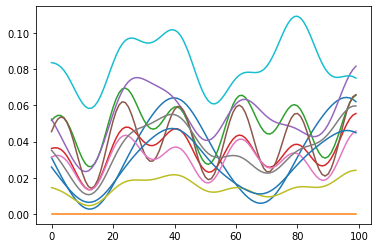

In [20]:
P = pd.DataFrame(D)
P.loc[:,10:20].plot(legend=False)

In [70]:
differ = diffusionNMF(n_components = 4, kernel = K, mask = None, n_iter = 100000, tol = 1e-9)

In [71]:
W,H = differ.fit_transform(D)

Max iterations reached, increase to converge on given tolerance


Text(0.5, 1.0, 'reconstructed V')

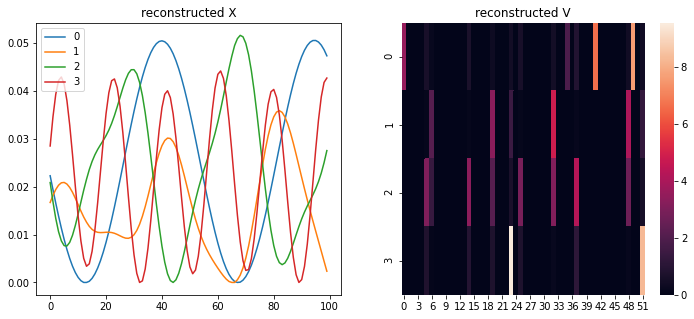

In [72]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
pd.DataFrame(W).plot(title = "reconstructed X", ax = ax[0])
seaborn.heatmap(H, square = False, cbar = True, ax = ax[1])
ax[1].set_title("reconstructed V")

Text(0.5, 1.0, 'Random Subset of Reconstructed Matrix')

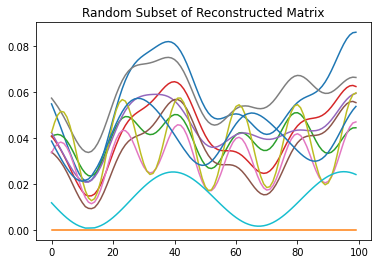

In [13]:
res = pd.DataFrame(W @ H @ K)
#rand_assort = random.choices(list(range(len(res.columns))), k = 10)
#res.plot(y = rand_assort)
res.loc[:,10:20].plot(legend = False)
plt.title("Random Subset of Reconstructed Matrix")

### Adding Noise

In [21]:
def noiser(matr, std_dev = None):
    # add noise to a matrix using gaussian random samples
    matr = np.matrix.copy(matr)
    if std_dev is None:
        std_dev = matr.std() / 100

    for rower in range(matr.shape[0]):
        for coler in range(matr.shape[1]):
            noisy = np.random.normal(scale = std_dev)
            if matr[rower, coler] + noisy < 0:
                matr[rower, coler] = 0
            else:
                matr[rower, coler] += noisy
    
            
    return matr

Text(0.5, 1.0, 'Subset of Data with Noise added')

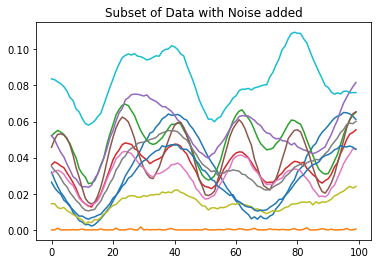

In [22]:
noise_D = noiser(D, 0.0005)
pd.DataFrame(noise_D).loc[:,10:20].plot(legend=False)
plt.title("Subset of Data with Noise added")

In [76]:
nd = pd.DataFrame(noise_D)

In [78]:
#nd.to_csv("./testing_data/D_4.csv")

### Hiding entries

In [23]:
# Creates a matrix of 0s -- unknown values -- and 1's -- known values ---
# in order to "mask" the data and split it into train/test sets
def train_mask(data, percent_hide):
    # "hide" a given percentage of the data
    num_entries = data.shape[0]*data.shape[1]
    mask = np.zeros(num_entries)
    mask[:int(num_entries * (1 - percent_hide))] = 1
    np.random.shuffle(mask)
    mask = mask.reshape(data.shape)
    
    return mask

In [24]:
hidden_mask = train_mask(noise_D, 0.2)

### Error Baseline

In [27]:
noise_base = 0.0005

In [18]:
state_L = pd.read_csv(os.path.join(par, "collected_data/state_laplacian.csv"), index_col = 0).to_numpy()
I = np.identity(52)
beta = 1
K = np.linalg.inv(I + beta*state_L)

In [28]:
# Holding True rank at 4
rank_tests = range(1,15)
ground_error = np.zeros(len(rank_tests))
prediction_error = np.zeros(len(rank_tests))
n_avg = 10
W,H = gen_sin_data(4, freqs[:4])
D = np.dot(W, np.dot(H,K))
noise_D = noiser(D, noise_base)

for r in rank_tests:    
    g_err = 0
    p_err = 0
    for j in range(n_avg):
        hidden_mask = train_mask(noise_D, 0.2)
        differ = DiffusionNMF(noise_D, K, M = hidden_mask, ncomponents = r, iterations = 100000, tol = 1e-9)
        differ.solver('MultUpdate')
        reconstructed = differ.X @ differ.V @ differ.K 
        
        #g_err += np.linalg.norm(noise_D - D) / np.linalg.norm(D)
        p_err += np.linalg.norm(reconstructed - D) / np.linalg.norm(D)
    
    g_err = np.linalg.norm(noise_D - D) / np.linalg.norm(D)
    p_err /= n_avg
    ground_error[r-1] = g_err
    prediction_error[r-1] = p_err

KeyboardInterrupt: 

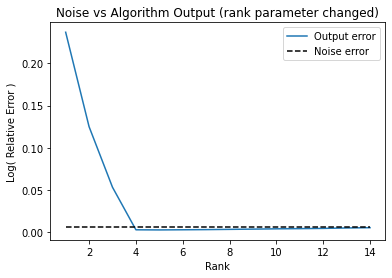

In [41]:
plt.plot(rank_tests, prediction_error, label = "Output error")
plt.plot(rank_tests, ground_error, "k--", label = "Noise error")
plt.xlabel("Rank")
plt.ylabel("Log( Relative Error )")
plt.title("Noise vs Algorithm Output (rank parameter changed)")
plt.legend()

In [25]:
rank_tests = range(1,15)
ground_error2 = np.zeros(len(rank_tests))
prediction_error2 = np.zeros(len(rank_tests))
n_avg = 10 

for r in rank_tests:
    W,H = gen_sin_data(r, freqs[:r])
    D = np.dot(W, np.dot(H,K))
    noise_D = noiser(D)
    hidden_mask = train_mask(noise_D, 0.2)
    
    g_err = np.linalg.norm(noise_D - D) / np.linalg.norm(D)
    p_err = 0
    for j in range(n_avg):
        differ = DiffusionNMF(noise_D, K, M = hidden_mask, ncomponents = r, iterations = 100000, tol = 1e-9)
        differ.solver('MultUpdate')
        reconstructed = differ.X @ differ.V @ differ.K 
        p_err += np.linalg.norm(reconstructed - D) / np.linalg.norm(D)
    
    p_err /= n_avg
    ground_error2[r-1] = g_err
    prediction_error2[r-1] = p_err

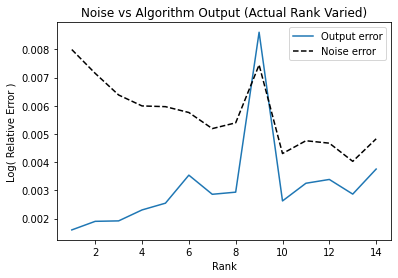

In [42]:
plt.plot(rank_tests, prediction_error2, label = "Output error")
plt.plot(rank_tests, ground_error2, "k--", label = "Noise error")
plt.xlabel("Rank")
plt.ylabel("Log( Relative Error )")
plt.title("Noise vs Algorithm Output (Actual Rank Varied)")
plt.legend()

In [32]:
L = pd.DataFrame(state_L)

In [35]:
keep = [5]

for i in range(L.shape[0]):
    if i not in keep:
        for j in range(L.shape[1]):
            if j not in keep:
                L.iloc[i,j] = 0

In [37]:
fiveK = np.linalg.inv(I + L)

### Grid Search

In [58]:
G = gridSearcher(noise_D, state_L, saver = "./testing_data/test_search.csv")
ranks = list(range(1,3))
betas = list(range(1,2))

In [59]:
start = time.process_time()
err = G.grid_search(ranks, betas)
end = time.process_time()
print(end - start)

0.0625


First going to do a grid search over the Rank/Beta parameters <br>
with the standard multiplicative update algorithm 

In [18]:
def grid_search(w,h, K_true, data_mask, algorithm, rank_list=range(1,11), beta_list=range(1,11),sparse_list = np.linspace(0,1,11)[5:], saver = False):
    I = np.identity(len(state_L))
    dd = np.dot(w,np.dot(h,K_true))
    
    # two cases for multiplicative update algorithm or Hoyer projection algorithm
    if algorithm == 'MultUpdate':
        # rows are ranks, columns are beta
        train_err = np.empty((len(rank_list), len(beta_list)))
        test_err = np.empty((len(rank_list), len(beta_list)))
        for rk in rank_list:
            for bt in beta_list:
                kb = np.linalg.inv(I + bt * state_L)
                #differ = DiffusionNMF(dd, kb, M = data_mask, ncomponents = rk, iterations = 5000, tol = 1e-20)
                differ = DiffusionNMF(dd, kb, M = None, ncomponents = rk, iterations = 5000, tol = 1e-20)
                differ.solver('MultUpdate')
                
                anti_mask = 1 - data_mask
                #trn = np.linalg.norm(data_mask * (dd - np.dot(differ.X, np.dot(differ.V, kb)))) / np.linalg.norm(data_mask * dd)
                #tst = np.linalg.norm(anti_mask * (dd - np.dot(differ.X, np.dot(differ.V, kb)))) / np.linalg.norm(anti_mask * dd)
                trn = np.linalg.norm((dd - np.dot(differ.X, np.dot(differ.V, kb)))) / np.linalg.norm(dd)
                tst = np.linalg.norm((dd - np.dot(differ.X, np.dot(differ.V, kb)))) / np.linalg.norm(dd)
                train_err[rk - 1,bt - 1] = trn
                test_err[rk - 1,bt - 1] = tst
                
    else:
        train_err = np.empty((len(rank_list), len(beta_list), len(sparse_list)))
        test_err = np.empty((len(rank_list), len(beta_list), len(sparse_list)))
        for rk in rank_list:
            for bt in beta_list:
                for sp in range(len(sparse_list)):
                    kb = np.linalg.inv(I + bt * state_L)
                    differ = DiffusionNMF(dd, kb, M = data_mask, ncomponents = rk, iterations = 5000, tol = 1e-20)
                    differ.solver('HoyerP', sparseness = sparse_list[sp])
                    
                    anti_mask = 1 - data_mask
                    trn = np.linalg.norm(data_mask * (dd - np.dot(differ.X, np.dot(differ.V, kb)))) / np.linalg.norm(data_mask * dd)
                    tst = np.linalg.norm(anti_mask * (dd - np.dot(differ.X, np.dot(differ.V, kb)))) / np.linalg.norm(anti_mask * dd)
                    train_err[rk - 1,bt - 1, sp] = trn
                    test_err[rk - 1,bt - 1, sp] = tst
    
    if saver:
        if len(train_err.shape) > 2:
            reshaped_tr = train_err.reshape(train_err.shape[0], -1)
            np.savetxt("hoyer_grid_train.csv", reshaped_tr, delimiter = ',')
            reshaped_tst = test_err.reshape(test_err.shape[0], -1)
            np.savetxt("hoyer_grid_test.csv", reshaped_tst, delimiter = ',')
        else:
            np.savetxt("multup_grid_train.csv", train_err, delimiter = ',')
            np.savetxt("multup_grid_test.csv", test_err, delimiter = ',')
    return train_err, test_err        

In [19]:
def grid_plot(data, labels, min_points, title, x_domain = list(range(1,11)), y_range = list(range(1,11)), rotation = 135):
    # labels should be in format [x label, y label, z label]
    # min points should be a dictionary of minimum points to mark -- {'point name':(x,y,z)}
    # make the grid for plotting:
    R,B = np.meshgrid(x_domain,y_range)
    fig = plt.figure(figsize = (10,10))
    
    ax = plt.axes(projection='3d')
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2])
    ax.view_init(None,rotation)
    #ax.plot_surface(R,B,multup_grid,rstride=1, cstride=1,cmap='viridis', edgecolor='none', alpha = 0.2)
    ax.plot_wireframe(R,B, data, cmap= 'viridis')
    #ax.plot([4]*10, [3]*10, np.linspace(0,np.max(multup_grid) + 0.05,10), 'red',linestyle = '--',alpha=1, linewidth=2)
    for point in min_points.keys():
        cord = min_points[point]
        ax.scatter(cord[0],cord[1],cord[2],c='r', marker = 'o')
        ax.text(cord[0],cord[1],cord[2], point, size=15,color ='k')

    plt.title(title)

In [20]:
def avg_train_test(w,h,K_true, algorithm,test_list,runs):
    d = np.dot(w,np.dot(h,K_true))
    sparse_list = np.append(np.linspace(0,1,11)[5:-1], [0.95])
    results = []
    for t in test_list:
        mult_grid_train_avg = np.nan
        mult_grid_test_avg = np.nan
        
        for r in range(runs):
            training_mask = train_mask(d, t)
            mult_grid_train, mult_grid_test = grid_search(w,h,K_true, training_mask, algorithm, saver = False)
            if np.isnan(mult_grid_train_avg):
                mult_grid_train_avg = mult_grid_train
                mult_grid_test_avg = mult_grid_test
                
            mult_grid_train_avg += mult_grid_train
            mult_grid_test_avg += mult_grid_test
            
        mult_grid_train_avg /= runs
        mult_grid_test_avg /= runs
        tr_min = np.unravel_index(np.argmin(mult_grid_test_avg), mult_grid_test_avg.shape)
        tst_min = np.unravel_index(np.argmin(mult_grid_test), mult_grid_test_avg.shape)
    
        if algorithm == "HoyerP":
            train_grids = [mult_grid_train_avg[:,:,i] for i in range(mult_grid_train_avg.shape[2])]
            test_grids = [mult_grid_test_avg[:,:,i] for i in range(mult_grid_test_avg.shape[2])]
        else:
            train_grids = [mult_grid_train_avg]
            test_grids = [mult_grid_test_avg]
            
        for g in range(len(train_grids)):
            # Note that this plotting function treats rows as y and columns as x
            if algorithm == "HoyerP":
                train_title = "Error on training set w/ sparseness = "+ str(sparse_list[g]) +" and "+ str(t*100) + "% hidden"
                test_title = "Error on test set w/ sparseness = "+ str(sparse_list[g]) +" and "+ str(t*100) + "% hidden"
            else:
                train_title = "Error on training set w/ " + str(t*100) + "% hidden"
                test_title = "Error on test set w/ " + str(t*100) + "% hidden"
                
            grid_plot(train_grids[g], ["beta","rank", "error"],
                      {'Actual':(3,4,mult_grid_train_avg[3,2]), 
                       'grid_search':(tr_min[1] + 1, tr_min[0] + 1, mult_grid_train_avg[tr_min])},
                     title = train_title)

            # Note that this plotting function treats rows as y and columns as x
            grid_plot(test_grids[g], ["beta","rank", "error"],
                      {'Actual':(3,4,mult_grid_test_avg[3,2]), 
                       'grid_search':(tst_min[1] + 1, tst_min[0] + 1, mult_grid_test_avg[tst_min])},
                     title = test_title)
        
        results.append(mult_grid_train_avg)
        results.append(mult_grid_test_avg)
        
    return np.array(results)
        

In [34]:
np.linspace(0.01,5,20)

array([0.01      , 0.27263158, 0.53526316, 0.79789474, 1.06052632,
       1.32315789, 1.58578947, 1.84842105, 2.11105263, 2.37368421,
       2.63631579, 2.89894737, 3.16157895, 3.42421053, 3.68684211,
       3.94947368, 4.21210526, 4.47473684, 4.73736842, 5.        ])

In [32]:
range(1,20)

range(1, 20)

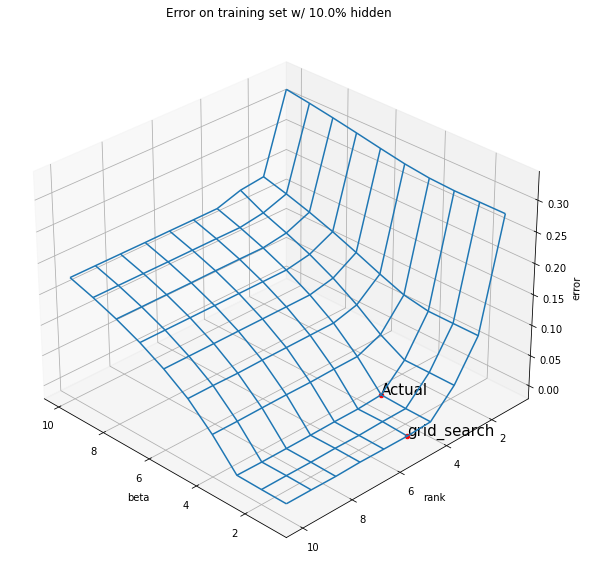

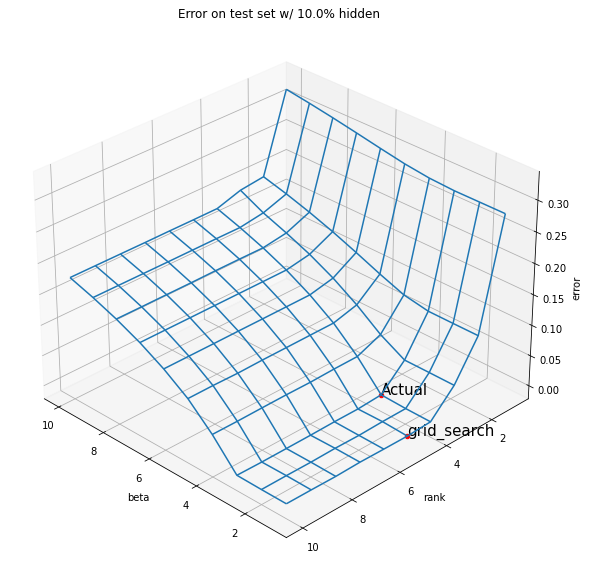

In [21]:
fir = avg_train_test(W,H,K,"MultUpdate", [0.1], runs = 1)

In [28]:
#grid_plot(fir[0], ["beta","rank", "error"],{},title="", rotation = 180)

### Average runs

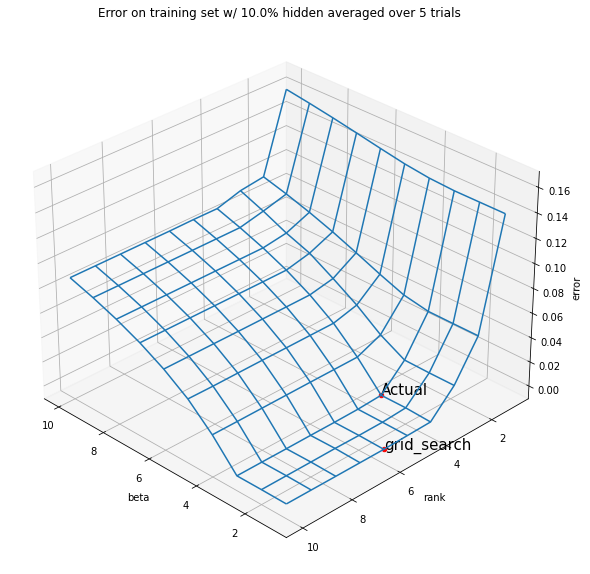

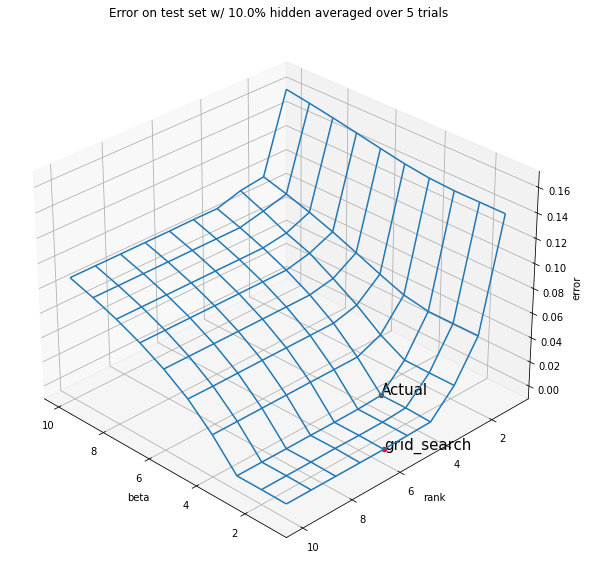

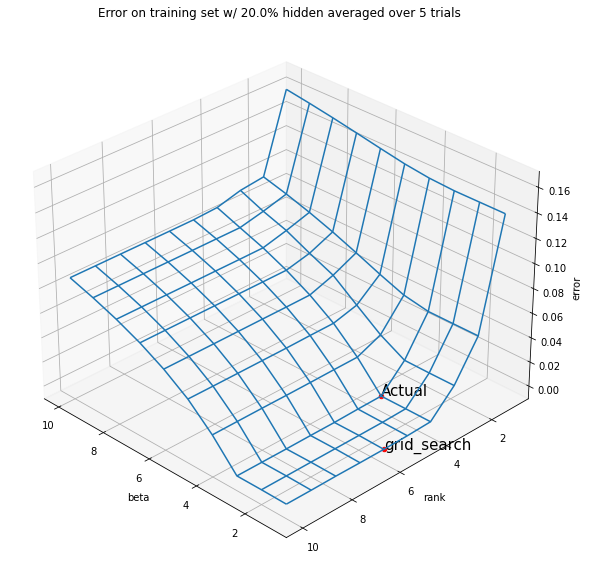

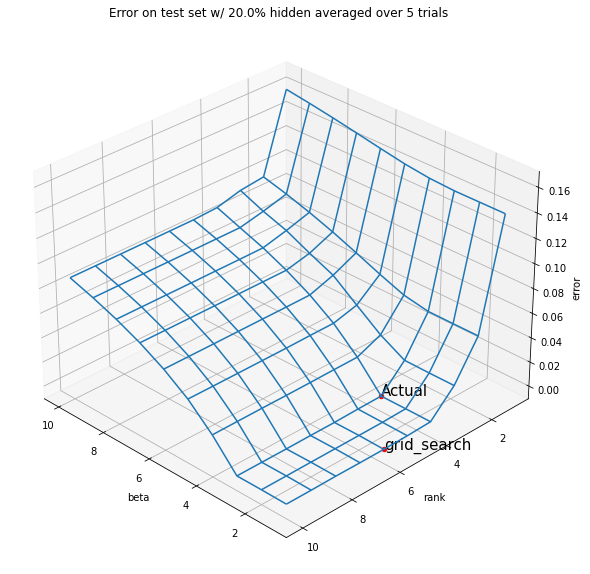

In [36]:
avgs = avg_train_test(W,H,K, "MultUpdate", [0.1, 0.2], runs = 5)

### Trying with different true beta values

#### Beta = 1

In [44]:
K1 = np.linalg.inv(I + 1*state_L)

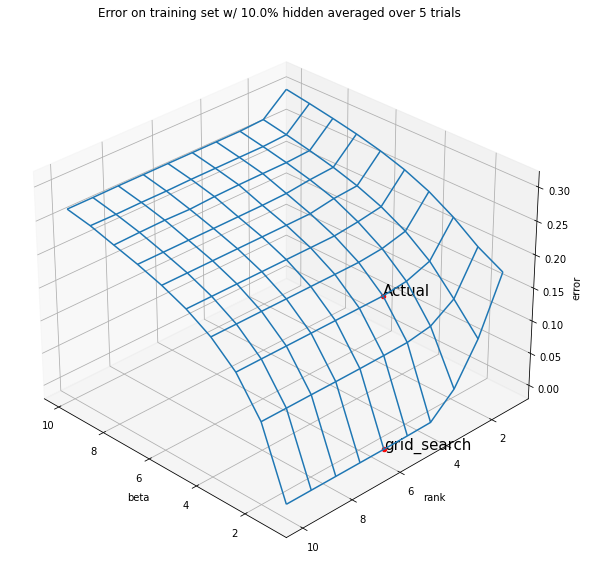

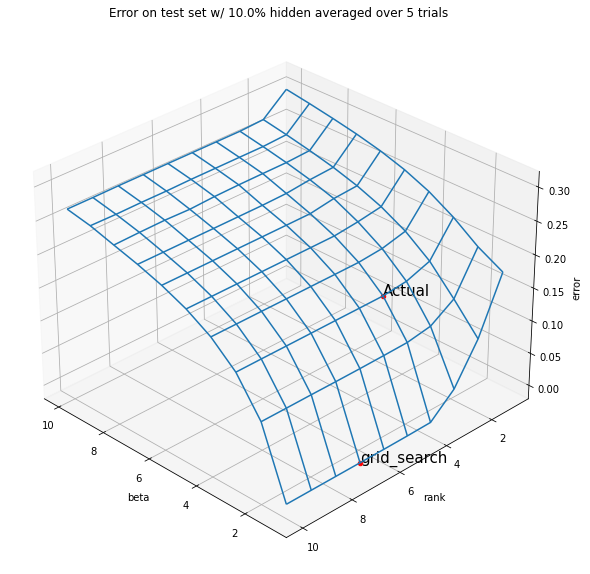

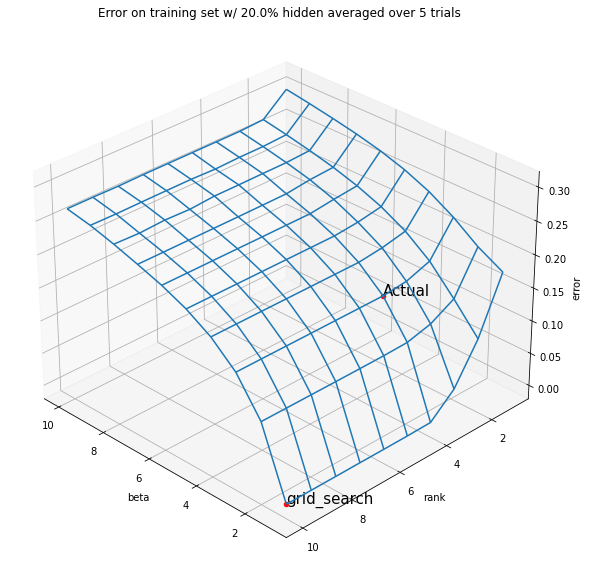

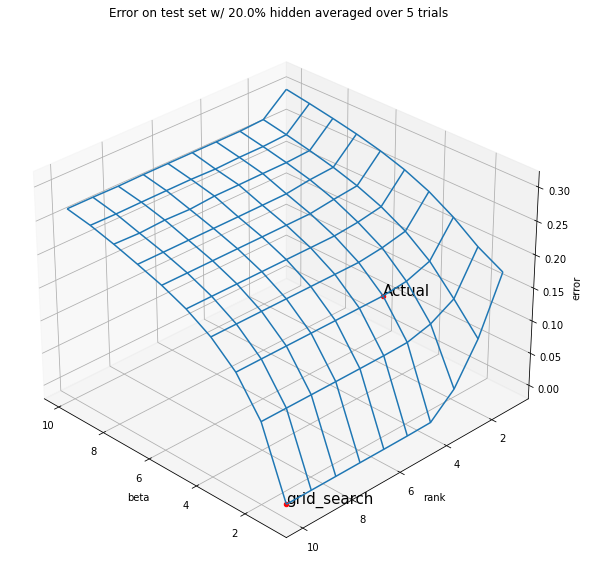

In [45]:
b1_avgs = avg_train_test(W,H,K1,"MultUpdate", [0.1, 0.2], runs = 5)

#### Beta = 7

In [46]:
K7 = np.linalg.inv(I + 7*state_L)

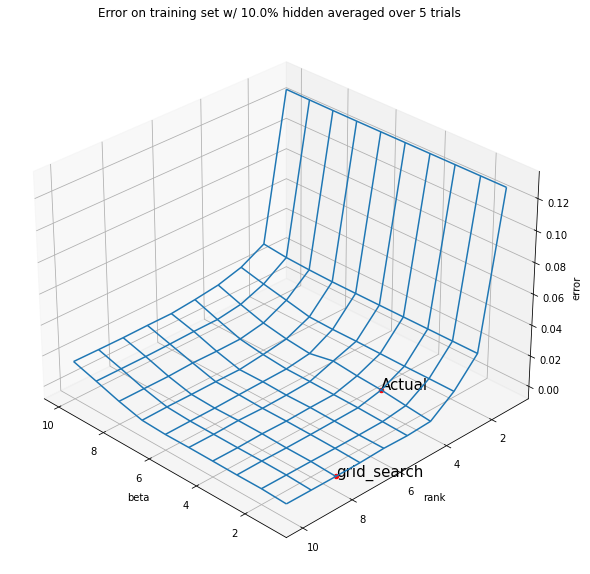

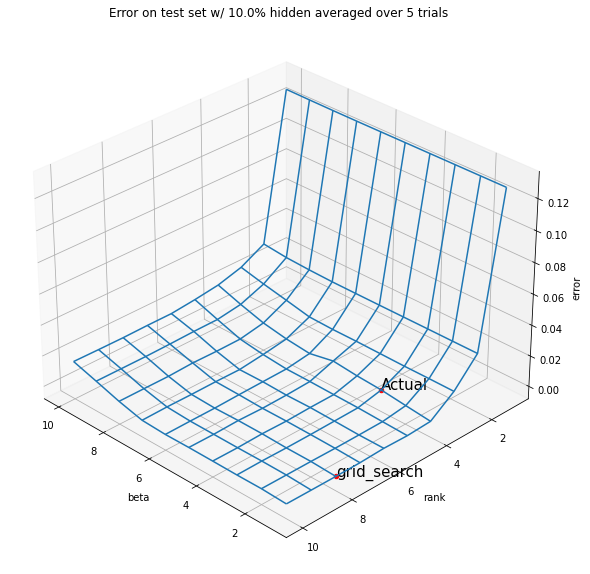

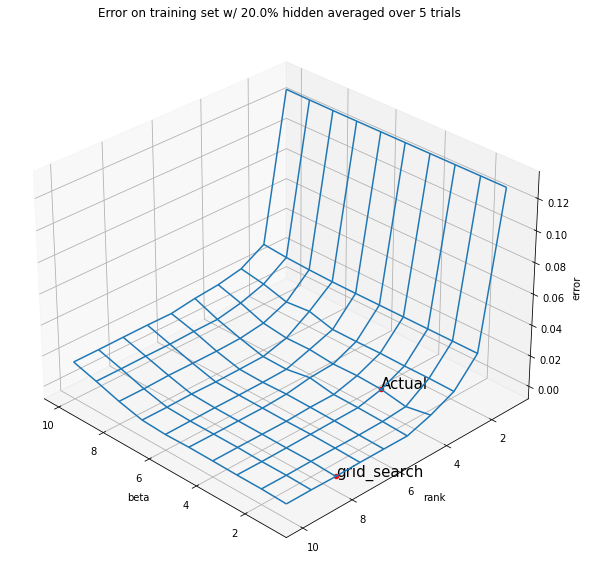

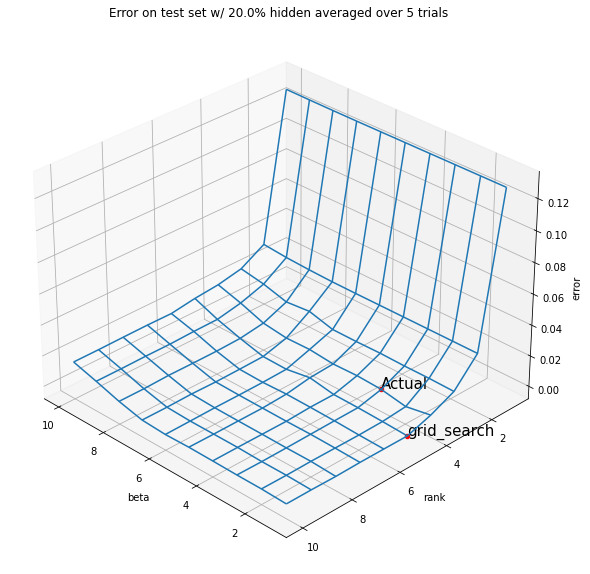

In [47]:
b7_avgs = avg_train_test(W,H,K7,"MultUpdate", [0.1, 0.2], runs = 5)

#### Beta = 10

In [48]:
K10 = np.linalg.inv(I + 10*state_L)

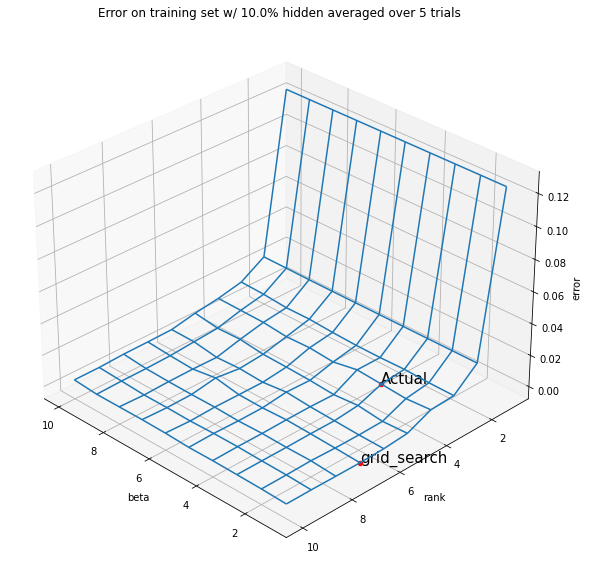

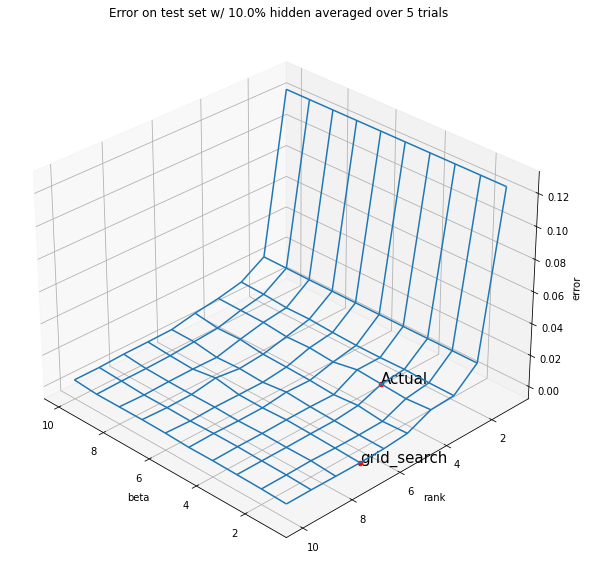

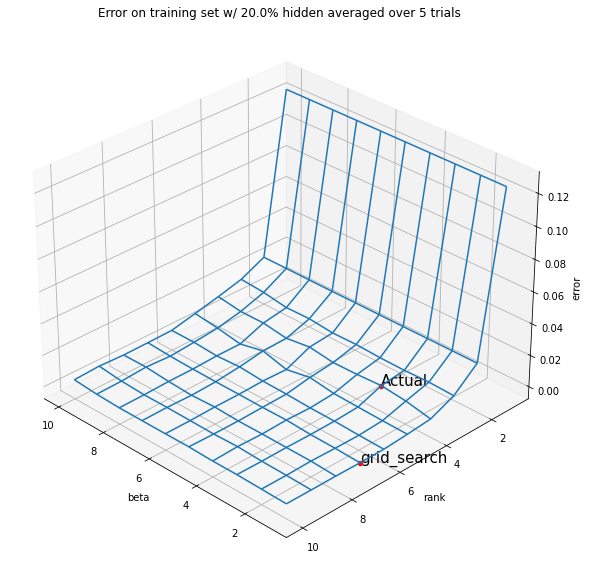

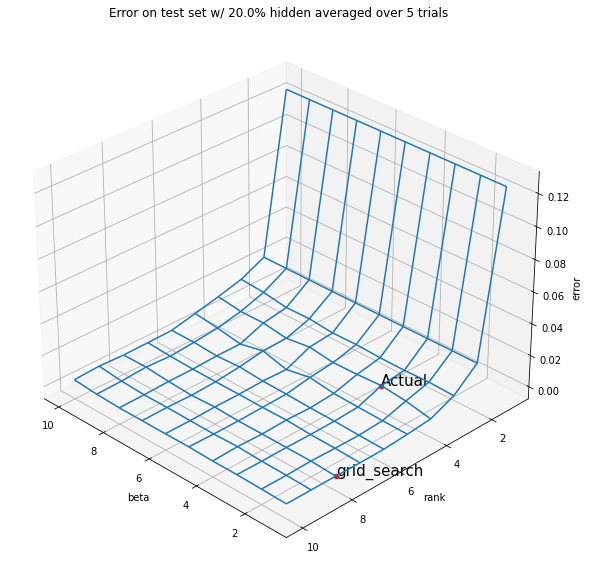

In [49]:
b10_avgs = avg_train_test(W,H,K10,"MultUpdate", [0.1, 0.2], runs = 5)